In [1]:
import cv2
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import normalize
from io import BytesIO
from PIL import Image

In [2]:
def extract_spectrum_from_url(filename, threshold=40, n_values=500):
    # Load the image from the URL
    response = requests.get(f'https://sdbs.db.aist.go.jp/API/ImageDisplayHandler.ashx?FileName={filename}&SpectralType=rm&FileType=Spectrl&Format=Old')
    image = Image.open(BytesIO(response.content))
    image = image.convert('RGB')  # Ensure the image has 3 channels
    image = np.array(image)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Define the fixed high-sensitivity area (bounding rectangle coordinates)
    top_row = 4
    bottom_row = 279
    left_col = 25
    right_col = 737

    # Crop the image to the defined high-sensitivity region
    cropped_gray = gray[top_row:bottom_row, left_col:right_col]

    spectrum_points = []
    height, width = cropped_gray.shape
    for y in range(height):
        for x in range(width):
            if cropped_gray[y, x]< threshold:
                spectrum_points.append([x, y])
    
    spectrum_points = np.array(spectrum_points)

    # Sort by x-coordinate to align with the wavenumber axis
    spectrum_points = spectrum_points[np.argsort(spectrum_points[:, 0])]

    # Extract x (wavenumber) and y (intensity) values
    x_pixels = spectrum_points[:, 0]
    y_pixels = spectrum_points[:, 1]

    # Flip y-axis (image origin is top-left, but plot origin is bottom-left)
    y_pixels = cropped_gray.shape[0] - y_pixels

    # Normalize to map pixels to approximate wavenumber and intensity ranges
    # Assuming x corresponds to 4000-0 cm^-1 and y is intensity 0-100
    x = np.interp(x_pixels, (x_pixels.min(), x_pixels.max()), (4000, 0))
    y = np.interp(y_pixels, (y_pixels.min(), y_pixels.max()), (0, 100))

    y_2 = []

        # Iterate over the range of x_i values
    for x_i in np.linspace(0, 4000, n_values):  # Generating 500 points between 4000 and 0
        # Find the index of the closest value in x, but prioritize higher y values
        closest_indices = np.where(np.abs(x - x_i) == np.min(np.abs(x - x_i)))[0]  # All closest indices
        best_index = closest_indices[np.argmax(y[closest_indices])]  # Select index with the highest y value
    
        y_2.append(y[best_index])  # Append the corresponding y value

    return np.linspace(0, 4000, n_values), np.array(y_2)

In [3]:
%%time

compound_library = {
    "methanol-d": "RM1733",
    "methylamine": "RM2121",
    "nitromethane": "RM28",
    "dichloromethane": "RM12",
    "benzhydrylamine": "RM3081",
}

num_points = 500
wavenumbers = np.linspace(0, 4000, num_points)

# Precompute reference spectra for each compound
reference_spectra = {}
for compound, compound_filename in compound_library.items():
    _, ref_spectrum = extract_spectrum_from_url(compound_filename, n_values=num_points)
    reference_spectra[compound] = ref_spectrum

CPU times: total: 1.08 s
Wall time: 4.26 s


In [4]:
%%time

def generate_mixture_spectrum(compounds, concentrations, reference_spectra, noise_level=0.03):
    """
    Generate a synthetic mixture spectrum by linearly combining 
    the reference spectra according to the provided concentrations.
    """
    spectrum = np.zeros_like(wavenumbers)
    
    for compound, concentration in zip(compounds, concentrations):
        spectrum += concentration * reference_spectra[compound]
    # Add some noise
    noise = np.random.normal(0, noise_level, size=spectrum.shape)
    return spectrum + noise

# Let's create a dataset
n_samples = 10000  # number of training samples
compounds = list(compound_library.keys())
M = len(compounds)

X_data = []
y_data = []

for _ in range(n_samples):
    # Generate random concentrations that sum to 1 (for simplicity).
    # In reality, you may allow them to be any set of random values.
    rand_concs = np.random.rand(M)
    rand_concs /= np.sum(rand_concs)  # normalize so sum=1

    for i in range(0, M):
        if np.random.rand() > 0.7:
            rand_concs[i] = 0
    
    # Get the synthetic mixture spectrum
    mixture_spectrum = generate_mixture_spectrum(compounds, rand_concs, reference_spectra)
    
    X_data.append(mixture_spectrum)
    y_data.append(rand_concs)

X_data = np.array(X_data)
y_data = np.array(y_data)

CPU times: total: 312 ms
Wall time: 431 ms


In [5]:
# Shuffle data
idx = np.random.permutation(n_samples)
X_data = normalize(X_data[idx])
y_data = normalize(y_data[idx])

# Train/test split
train_size = int(0.8 * n_samples)
X_train, X_test = X_data[:train_size], X_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

In [6]:
%%time
# Add early stopping ot prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Build a TensorFlow Neural Network
regressor = Sequential([
    Dense(128, activation='relu', input_shape=(num_points,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(M, activation='linear')  # M outputs, one for each compound concentration
])

regressor.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
regressor_history = regressor.fit(
    X_train, y_train,
    epochs=50, batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

regressor.save('models/model.keras')

Epoch 1/50


C:\Users\aniru\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0594 - mae: 0.1690 - val_loss: 4.0262e-04 - val_mae: 0.0149
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.1868e-04 - mae: 0.0135 - val_loss: 2.3683e-04 - val_mae: 0.0117
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6391e-04 - mae: 0.0098 - val_loss: 1.2710e-04 - val_mae: 0.0082
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0827e-04 - mae: 0.0081 - val_loss: 1.1732e-04 - val_mae: 0.0079
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.3622e-05 - mae: 0.0072 - val_loss: 8.3893e-05 - val_mae: 0.0064
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.6341e-05 - mae: 0.0069 - val_loss: 9.5966e-05 - val_mae: 0.0070
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7566e-05 - mae: 0.0065 - val_loss: 8.2784e-05 - val_mae: 0.0063
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.9623e-05 - mae: 0.0061 - val_loss: 7.3458e-05 - val_mae: 0.0059
Epoch 9

In [41]:
# Evaluate the Model
mse, mae = regressor.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {mse}, Test MAE: {mae}")

Test MSE: 0.00016156144556589425, Test MAE: 0.004753114655613899


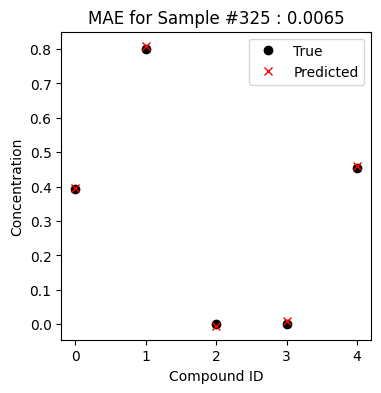

In [40]:
predictions = regressor.predict(X_test, verbose=0)
idx_plot = np.random.randint(0, len(X_test))

sample_mae = mean_absolute_error(predictions[idx_plot], y_test[idx_plot])

x_range = range(0, len(predictions[idx_plot]))
plt.figure(figsize=(4, 4))
plt.plot(x_range, y_test[idx_plot], linestyle='none', marker='o', color='black', label='True')
plt.plot(x_range, predictions[idx_plot], linestyle='none', marker='x', color='red', label='Predicted')
plt.legend(loc='upper right')
plt.title(f"MAE for Sample #{idx_plot} : {sample_mae:0.4f}")
plt.ylabel('Concentration')
plt.xlabel('Compound ID')
plt.show()